In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df =  pd.read_csv(r'D:\#PROJECTS\churn-project\data\cleaned_telco.csv')
df.head()

,Gender,Age,Senior Citizen,Married,Dependents,Referred a Friend,Number of Referrals,Tenure in Months,Phone Service,Avg Monthly Long Distance Charges,...,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Satisfaction Score,Churn Label,CLTV,Contract_One Year,Contract_Two Year,Payment Method_Credit Card,Payment Method_Mailed Check
0,1,78,1,0,0,0,0,1,0,0.00,...,0.00,20,0.00,3,1,5433,0,0,0,0
1,0,74,1,1,1,1,1,8,1,48.85,...,0.00,0,390.80,3,1,5302,0,0,1,0
2,1,71,1,0,1,0,0,18,1,11.33,...,45.61,0,203.94,2,1,3179,0,0,0,0
3,0,78,1,1,1,1,1,25,1,19.76,...,13.43,0,494.00,2,1,5337,0,0,0,0
4,0,80,1,1,1,1,1,37,1,6.33,...,0.00,0,234.21,2,1,2793,0,0,0,0


In [4]:
# check shapes and imbalance
print(df.shape)
print(df['Churn Label'].unique())
print(df['Churn Label'].value_counts(normalize=True))

# check missing
print(df.isna().sum().sort_values(ascending=False).head(20))

(7043, 34)
[1 0]
Churn Label
0    0.73463
1    0.26537
Name: proportion, dtype: float64
Gender                               0
Age                                  0
Senior Citizen                       0
Married                              0
Dependents                           0
Referred a Friend                    0
Number of Referrals                  0
Tenure in Months                     0
Phone Service                        0
Avg Monthly Long Distance Charges    0
Multiple Lines                       0
Internet Service                     0
Avg Monthly GB Download              0
Online Security                      0
Online Backup                        0
Device Protection Plan               0
Premium Tech Support                 0
Streaming TV                         0
Streaming Movies                     0
Streaming Music                      0
dtype: int64


In [5]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Churn Label'])
y = df['Churn Label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

Baseline model

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

lr = LogisticRegression(max_iter=5000, class_weight='balanced', random_state=42)
lr.fit(X_train, y_train)

proba = lr.predict_proba(X_test)[:,1]
pred = (proba >= 0.5).astype(int)

print("ROC AUC:", roc_auc_score(y_test, proba))
print(classification_report(y_test, pred))

ROC AUC: 0.9868247694334651
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1035
           1       0.88      0.92      0.90       374

    accuracy                           0.94      1409
   macro avg       0.92      0.94      0.93      1409
weighted avg       0.95      0.94      0.94      1409



c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 5000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=5000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [10]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    class_weight='balanced',
    random_state=42
)
rf.fit(X_train, y_train)

print(f"\ntraining accuracy: {rf.score(X_train, y_train)*100:.2f}%")
print(f"test accuracy: {rf.score(X_test, y_test)*100:.2f}%")


training accuracy: 100.00%
test accuracy: 95.81%


In [9]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=3  # for imbalance
)
xgb.fit(X_train, y_train)
print(f"\ntraining accuracy: {xgb.score(X_train, y_train)*100:.2f}%")
print(f"test accuracy: {xgb.score(X_test, y_test)*100:.2f}%")


training accuracy: 99.77%
test accuracy: 95.60%


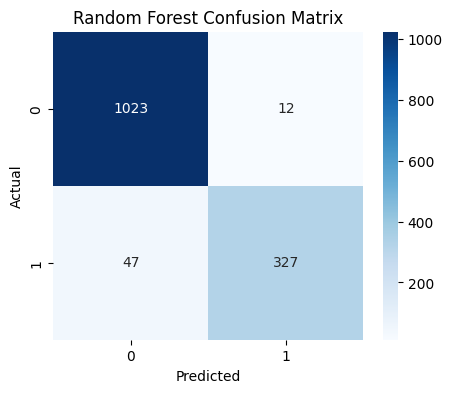

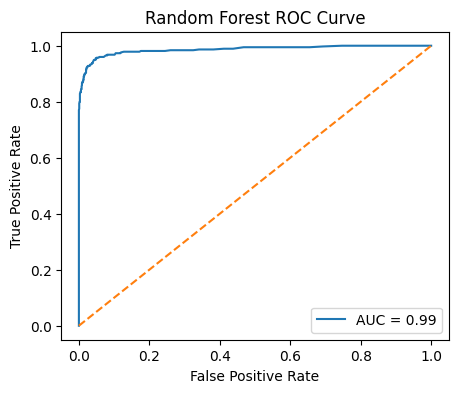

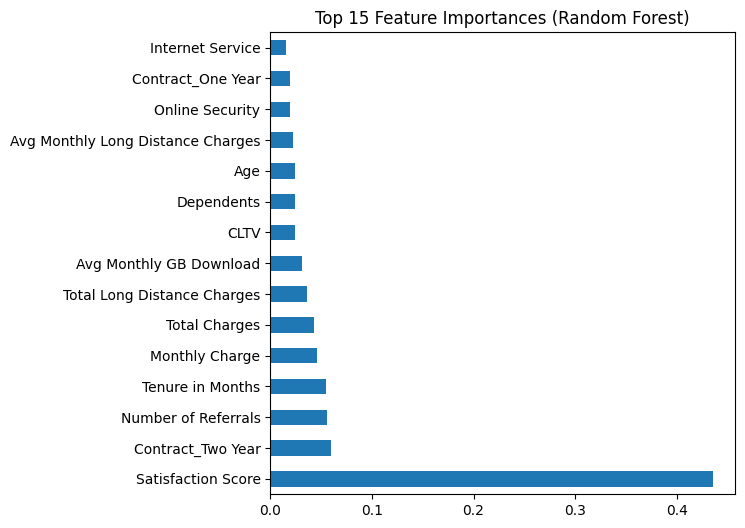

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = rf.predict(X_test)


cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



#  ROC 
from sklearn.metrics import roc_curve, auc

y_prob = rf.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],'--')
plt.title("Random Forest ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()




# Feature Importance Plot
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh', figsize=(6,6))
plt.title("Top 15 Feature Importances (Random Forest)")
plt.show()


In [16]:
importances = xgb.feature_importances_
features = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
print(features.head(15))

Satisfaction Score            0.412594
Internet Service              0.140418
Online Security               0.102271
Contract_Two Year             0.059846
Number of Referrals           0.039690
Contract_One Year             0.038023
Dependents                    0.021681
Payment Method_Credit Card    0.015311
Tenure in Months              0.011494
Senior Citizen                0.011440
Premium Tech Support          0.010589
Streaming Movies              0.010120
Paperless Billing             0.009221
Referred a Friend             0.008642
Monthly Charge                0.008601
dtype: float32


In [17]:
importances = rf.feature_importances_
features = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
print(features.head(15))

Satisfaction Score                   0.435677
Contract_Two Year                    0.060143
Number of Referrals                  0.056193
Tenure in Months                     0.054453
Monthly Charge                       0.046461
Total Charges                        0.042775
Total Long Distance Charges          0.036409
Avg Monthly GB Download              0.031441
CLTV                                 0.024393
Dependents                           0.024286
Age                                  0.024092
Avg Monthly Long Distance Charges    0.022050
Online Security                      0.019830
Contract_One Year                    0.019023
Internet Service                     0.015568
dtype: float64


In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [25]:
import joblib
import os

os.makedirs("models", exist_ok=True)

joblib.dump(rf, "models/churn_model.pkl")
joblib.dump(scaler, "models/scaler.pkl")
feature_list = df.drop("Churn Label", axis=1).columns.to_list()
joblib.dump(feature_list, "models/model_features.pkl")

['models/model_features.pkl']